# Tutorial: Running inference with the MCSPACE model on a perturbed dataset example

This tutorial demonstates fitting the model to a perturbation experiment. We use samples from mouse faecal pellets of mice on a standard low fat diet and mice given a high fat diet perturbation. The original datasets are taken from: 

Sheth, R.U., Li, M., Jiang, W., Sims, P.A., Leong, K.W. and Wang, H.H., 2019. Spatial metagenomic characterization of microbial biogeography in the gut. Nature biotechnology, 37(8), pp.877-883.

In [1]:
import numpy as np
import torch
from mcspace.model import MCSPACE
from mcspace.trainer import train_model
from mcspace.data_utils import get_data, get_lf_hf_pair_data
from mcspace.utils import get_device, pickle_load, pickle_save, get_summary_stats
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import mcspace.visualization as vis

In [2]:
torch.manual_seed(0)
np.random.seed(0)

# Paths

In [3]:
rootpath = Path("../")
datapath = rootpath / "data"

# Load the MaPS-seq low fat and high fat datasets

The full datasets are contained in the `../data` directory. We use the `get_lf_hf_pair_data()` method here to automatically filter and load the dataset in the proper format for both samples.

The full low fat dataset contains 6269 particles and the high fat dataset contains 33244 particles, both with 223 OTUs. Many of these OTUs are of very low abundance and many particles have very low number of reads. We first filter our dataset, removing OTUs below a minimum relative abundance of 0.5% in either sample. We also remove all particles with fewer than 100 reads and over 10000 reads.

In [4]:
min_abundance=0.005
min_reads=100
max_reads=10000

In [5]:
reads, taxonomy = get_lf_hf_pair_data(min_abundance=min_abundance, min_reads=min_reads, max_reads=max_reads, datapath=datapath)

The resulting dataset is a dictionary indexed by time. The values of the dictionary are also dictionaries, indexed by subject. The values for each time and subject is a matrix of count data giving number of particles by the number of OTUs.

In [6]:
reads.keys()

dict_keys([0, 1])

Here the time points correspond to 0='low fat' 1='high fat'

In [7]:
reads[0].keys()

dict_keys(['s1'])

In [8]:
reads[0]['s1'].shape

(483, 54)

In [9]:
reads[1]['s1'].shape

(1366, 54)

After filtering we have 483 particles in the low fat dataset and 1366 particles in the high fat dataset. The total number of OTUs remaining is 54.

### We can look at the OTUs that are kept after filtering by looking at the taxonomy dataframe
Each row in the taxonomy corresponds to a column in the count matrix

In [10]:
taxonomy.head()

,Kingdom,Phylum,Class,Order,Family,Genus
Unnamed: 0,,,,,,
Otu19,Bacteria,Tenericutes,Mollicutes,Anaeroplasmatales,Anaeroplasmataceae,Anaeroplasma
Otu21,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Sporobacter
Otu13,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,na
Otu62,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,na
Otu9,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,na


# Setup model

We next setup model parameters and create a MCSPACE model object.

In [11]:
# The get device function returns a torch device object (cpu or cuda)
device = get_device()

In [12]:
# The get data method returns data used for model inference given read data and the device
data = get_data(reads, device)

We next create parameters for the number of OTUs in the dataset. The number of assemblages the model is allowed to learn. The times and subjects present in the dataset. The times that are perturbed (if any), as well as paramters for the perturbation indicator prior and sparsity indicator prior.

In [13]:
num_otus = taxonomy.shape[0]
num_assemblages = 50
times = list(reads.keys())
subjects = list(reads[times[0]].keys())

Perturbed times are set by indicating a 1 if present and 0 if not. Here since the second time point is perturbed, we set the second value in the perturbed times parameter to 1. The prior is set so that in expectation no assemblages are assumed to be perturbed a priori.

In [14]:
perturbed_times = [0, 1]
perturbation_prior = 0.5/num_assemblages

The sparsity prior is set to have 1 assemblage present in expectation. Additionally, we specify a power so that the prior scales with the amount of data given in the model. This is because the Multinomial noise model also scales with the data. We rescale the prior to balance the likelihood with the prior. We set the prior power to 0.1 times the number of reads in the data.

In [15]:
sparsity_prior = 0.5/num_assemblages

num_reads = 0
for t in times:
    for s in subjects:
        num_reads += reads[t][s].sum()
sparsity_prior_power = 0.1*num_reads 

Additional options for time series data. We can set a process variance and prior to model drift over time as well. Since we only have one time point on each perturbation in this example, we turn these options off.

In [16]:
process_var_prior = None
add_process_var=False

### instantiate model

In [17]:
model = MCSPACE(num_assemblages,
                num_otus,
                times,
                subjects,
                perturbed_times,
                perturbation_prior,
                sparsity_prior,
                sparsity_prior_power,
                process_var_prior,
                device,
                add_process_var)

In [18]:
model.to(device)

MCSPACE(
  (beta_params): AssemblageProportions(
    (sparsity_params): SparsityIndicatorPowerScale()
    (perturbation_indicators): PerturbationIndicators()
    (perturbation_magnitude): PerturbationMagnitude(
      (q_encode): Sequential(
        (0): Linear(in_features=54, out_features=10, bias=True)
        (1): Softplus(beta=1, threshold=20)
        (2): Linear(in_features=10, out_features=10, bias=True)
        (3): Softplus(beta=1, threshold=20)
      )
      (q_mu_params): Linear(in_features=10, out_features=50, bias=True)
      (q_var_params): Linear(in_features=10, out_features=50, bias=True)
    )
    (latent_distrib): LatentTimeSeriesMixtureWeights(
      (q_encode): Sequential(
        (0): Linear(in_features=54, out_features=50, bias=True)
        (1): Softplus(beta=1, threshold=20)
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): Softplus(beta=1, threshold=20)
      )
      (q_mu_params): Linear(in_features=50, out_features=50, bias=True)
    

# Train model

Set the number of training epochs.

In [19]:
num_epochs = 5000

Train the model.

In [20]:
elbos = train_model(model, data, num_epochs)


epoch 0
ELBO =  tensor(28151924., device='cuda:0', grad_fn=<NegBackward0>)

epoch 100
ELBO =  tensor(24367542., device='cuda:0', grad_fn=<NegBackward0>)

epoch 200
ELBO =  tensor(21206552., device='cuda:0', grad_fn=<NegBackward0>)

epoch 300
ELBO =  tensor(18960114., device='cuda:0', grad_fn=<NegBackward0>)

epoch 400
ELBO =  tensor(17433286., device='cuda:0', grad_fn=<NegBackward0>)

epoch 500
ELBO =  tensor(16350252., device='cuda:0', grad_fn=<NegBackward0>)

epoch 600
ELBO =  tensor(15633873., device='cuda:0', grad_fn=<NegBackward0>)

epoch 700
ELBO =  tensor(15126075., device='cuda:0', grad_fn=<NegBackward0>)

epoch 800
ELBO =  tensor(14830059., device='cuda:0', grad_fn=<NegBackward0>)

epoch 900
ELBO =  tensor(14661399., device='cuda:0', grad_fn=<NegBackward0>)

epoch 1000
ELBO =  tensor(14547200., device='cuda:0', grad_fn=<NegBackward0>)

epoch 1100
ELBO =  tensor(14471294., device='cuda:0', grad_fn=<NegBackward0>)

epoch 1200
ELBO =  tensor(14412332., device='cuda:0', grad_fn=<

# Plot training loss over epochs
We plot the training loss over time to ensure the model has converged

Text(0, 0.5, 'ELBO loss')

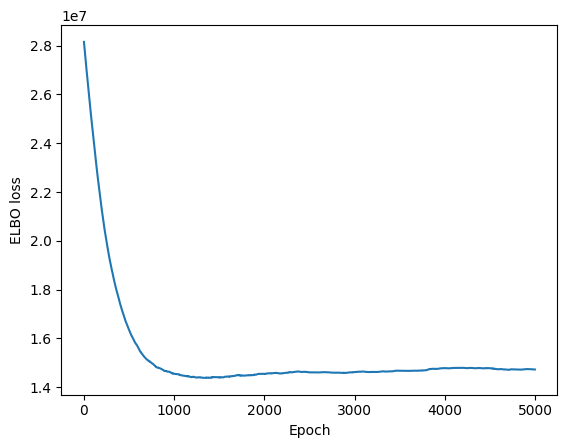

In [21]:
fig, ax = plt.subplots()
ax.plot(elbos)
ax.set_xlabel("Epoch")
ax.set_ylabel("ELBO loss")

# Visualize the results
We obtain posterior summary values for perturbation Bayes factors, assemblage proportions, and assemblages with the `get_summary_stats()` method.

In [22]:
pert_bf, beta, theta = get_summary_stats(model, data)

Perturbation Bayes factors are given for each learned assemblage

In [23]:
pert_bf.shape

(16, 1)

Assemblage proportions are stored in a (Number of assemblages x Number time points x Number subjects) array

In [24]:
beta.shape

(16, 2, 1)

Learned assemblages are stored in a (Number of assemblages x Number of OTUs) array

In [25]:
theta.shape

(16, 54)

We next visualize the learned assemblages and their proportions. We first cluster the otus and assemblages to get a more informative visulalization.

In [26]:
otu_order, assemblage_order = vis.get_clustered_otu_assemblage_ordering(theta)

Finally, we can visualize the inferred spatial assemblages and their proprotions.

In [27]:
labels = ["Low fat", "High fat"]

(<Figure size 850x1320 with 4 Axes>,
 <Axes: >,
 <Axes: xlabel='Spatial assemblage'>,
 <matplotlib.colorbar.Colorbar at 0x181484265c0>)

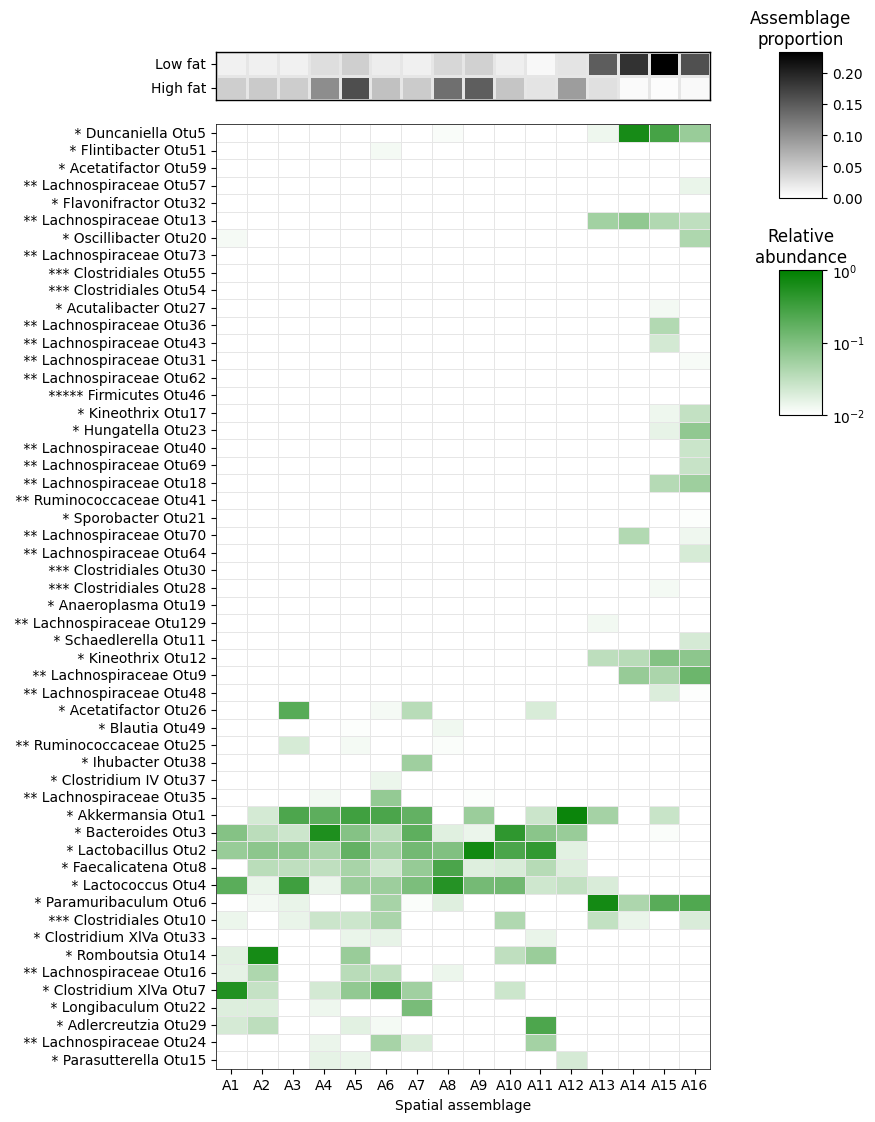

In [28]:
vis.render_proportions_and_assemblages(beta, theta, taxonomy, otu_order, assemblage_order, ylabels=labels)

We can also see which assemblages were signficantly perturbed and by how much

In [29]:
# The change in assemblage proportions is given by taking the second time point minus the first
betadiff = beta[:,1,:] - beta[:,0,:]

C:\Users\Gary\anaconda3\envs\mcspace3\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\Gary\anaconda3\envs\mcspace3\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
C:\Users\Gary\anaconda3\envs\mcspace3\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\Gary\anaconda3\envs\mcspace3\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


(<Figure size 850x1320 with 6 Axes>,
 <Axes: >,
 <Axes: >,
 <Axes: xlabel='Spatial assemblage'>,
 <Axes: title={'center': 'Perturbation\nBayes Factor'}>,
 <matplotlib.colorbar.Colorbar at 0x18131244520>)

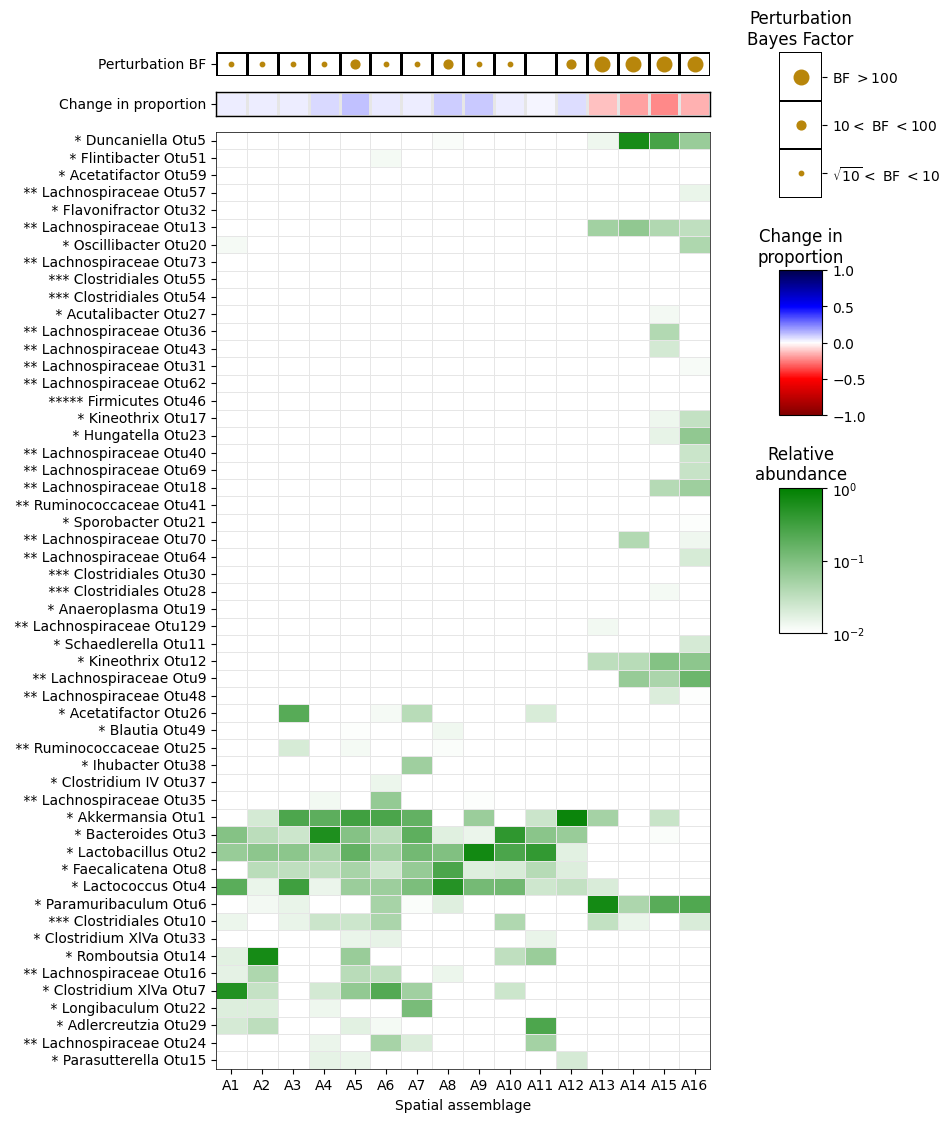

In [30]:
vis.render_perturbation_effect_and_assemblages(pert_bf, betadiff, theta, taxonomy, otu_order, assemblage_order)